# LuGRE Data Analysis (AA272 Final Project)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import re
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
from pathlib import Path
from pprint import pprint
from datetime import timedelta, datetime
import gnss_lib_py as glp
from gnss_lib_py.utils.ephemeris_downloader import load_ephemeris
from astropy.time import Time # datetime to TAI

plt.rcdefaults()

In [2]:
import pylupnt as pnt

outdir = Path().joinpath("data/new_lugre")
# outdir = Path(pnt.get_output_path()).joinpath("LuGRE")
if not outdir.exists():
    os.makedirs(outdir)

Downloaded data to LuPNT_data


## Import LuGRE data

In [4]:
from src.lugre_parser import *

data_path = Path().joinpath("LuGRE Mission Data/L0/TLM/")
set_ids = get_unique_timestamps(data_path) # get all unique timestamps in the directory
# shrink set_ids to the ones on lunar surface
surf_ids = [set_id for set_id in set_ids if "_S_" in set_id]
print(len(surf_ids), "surface data sets found.")

# create output directories for every surf ids to save outputs
for set_id in surf_ids:
    directory = outdir.joinpath(set_id)
    if not directory.exists():
        os.makedirs(directory)

set_id = surf_ids[5]
# load data for a specific set_id
lugre_df = lugre_parser(data_path, set_id)
print(set_id)

display(lugre_df['info'])
# pprint(lugre_df)

# set savepath for specific set_id
savepath = outdir.joinpath(set_id)

7 surface data sets found.
20250316_191448_03H_S_OP77_1


/Users/magi-nerv/Space-Specifically/Stanford/AA-272-GPS-Final/src/lugre_parser.py:62: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/magi-nerv/Space-Specifically/Stanford/AA-272-GPS-Final/src/lugre_parser.py:62: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,date,time,duration,phase,opnumber,index
0,20250316,191448,03H,S,OP77,1


In [5]:
rxTimes, (rxTime_start, src_min), (rxTime_end, src_max) = get_unique_times(lugre_df, minmax=True)

print(f"Earliest time: {rxTime_start} from {src_min}")
print(f"Latest time: {rxTime_end} from {src_max}")

# convert to TAI
gps_week_start, sec_into_week_start = gps_seconds_to_gps_weeks(rxTime_start)
gps_week_end, sec_into_week_end = gps_seconds_to_gps_weeks(rxTime_end)
print(f"GPS Week: {gps_week_start}, Start sec into week: {sec_into_week_start}, End sec into week: {sec_into_week_end}")

# utc_start = pnt.gps_weeks_to_datetime(gps_week_start, round(sec_into_week_start))
# utc_end = pnt.gps_weeks_to_datetime(gps_week_end, round(sec_into_week_end))
utc_start = glp.gps_millis_to_datetime(rxTime_start*1000)
utc_end = glp.gps_millis_to_datetime(rxTime_end*1000)
print(f"UTC Start time: {utc_start}, UTC End time: {utc_end}")

# tai_start = pnt.datetime_to_tai(utc_start)
# tai_end = pnt.datetime_to_tai(utc_end)
j2000_epoch = Time(datetime(2000, 1, 1, 12, 0, 0)).unix_tai
# print(gps_epoch)
tai_start = Time(utc_start, scale='utc').unix_tai - j2000_epoch  # From Astropy
tai_end = Time(utc_end, scale='utc').unix_tai - j2000_epoch  # From Astropy
print(f"TAI Start time: {tai_start}, TAI End time: {tai_end}")
tspan_tai = tai_start + np.linspace(0, tai_end - tai_start, 200)

Earliest time: 1426191726.63372 from acq
Latest time: 1426197553.43584 from acq
GPS Week: 2358, Start sec into week: 73326.63371992111, End sec into week: 79153.43583989143
UTC Start time: 2025-03-16 20:21:48.633720+00:00, UTC End time: 2025-03-16 21:58:55.435840+00:00
TAI Start time: 795428513.6337199, TAI End time: 795434340.4358399


### Get receiver ECEF positions

In [6]:
# get ECEF position of LuGRE receiver
rx_ecef = lugre_df['nav'][["posX", "posY", "posZ"]].to_numpy()
# conversion needs precise time from each ecef position from dataset
rxTime_nav = lugre_df['nav']["rxTime"]
rxTime_nav_tai = np.zeros_like(rxTime_nav)
for i, t in enumerate(rxTime_nav):
    # gps_week, sec_into_week = gps_seconds_to_gps_weeks(t)
    # rxTime_nav_dt = pnt.gps_weeks_to_datetime(gps_week, sec_into_week)
    # rxTime_nav_tai[i] = pnt.datetime_to_tai(rxTime_nav_dt)
    rxTime_nav_dt: datetime = glp.gps_millis_to_datetime(t*1000)
    # tai_time = rxTime_nav_dt + timedelta(seconds=37) # Time(rxTime_nav_dt, scale='utc').tai
    rxTime_nav_tai[i] = rxTime_nav_dt.timestamp() + 37

# print(rxTime_nav_tai[0])
# print(rxTime_nav[0])
# print(rxTime_nav_tai[-1])
# print(rxTime_nav)
# convert to Moon PA frame to plot
rx_mpa = pnt.convert_frame(rxTime_nav_tai, rx_ecef, pnt.ECEF, pnt.MOON_PA)

### Plot ECEF positions

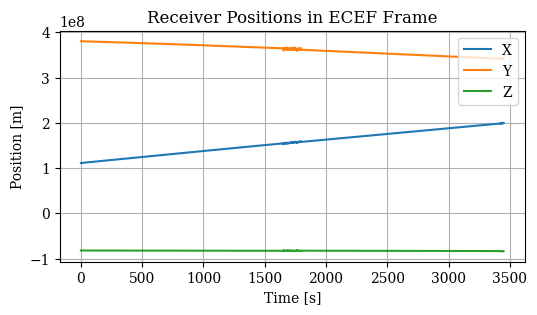

In [7]:
plt.figure(figsize=(6, 3))
plt.plot(rxTime_nav_tai - rxTime_nav_tai[0], rx_ecef[:,0], label='X')
plt.plot(rxTime_nav_tai - rxTime_nav_tai[0], rx_ecef[:,1], label='Y')
plt.plot(rxTime_nav_tai - rxTime_nav_tai[0], rx_ecef[:,2], label='Z')
plt.title("Receiver Positions in ECEF Frame")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.grid()
plt.legend()

# Export figure to pdf
plt.savefig(savepath.joinpath("NAV_ECEF.png"))
plt.show()

### Plot receiver positions in Moon PA (frame)

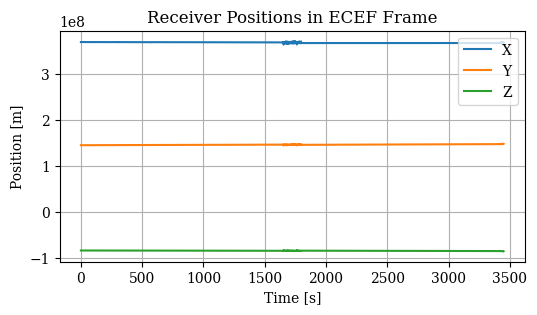

In [8]:
plt.figure(figsize=(6, 3))
plt.plot(rxTime_nav_tai - rxTime_nav_tai[0], rx_mpa[:,0], label='X')
plt.plot(rxTime_nav_tai - rxTime_nav_tai[0], rx_mpa[:,1], label='Y')
plt.plot(rxTime_nav_tai - rxTime_nav_tai[0], rx_mpa[:,2], label='Z')
plt.title("Receiver Positions in ECEF Frame")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.grid()
plt.legend()

# Export figure to pdf
plt.savefig(savepath.joinpath("NAV_ECEF.png"))
plt.show()

In [ ]:
pnt.LUPNT_DATA_PATH

'/Users/magi-nerv/Space-Specifically/Stanford/AA-272-GPS-Final/LuPNT_data'

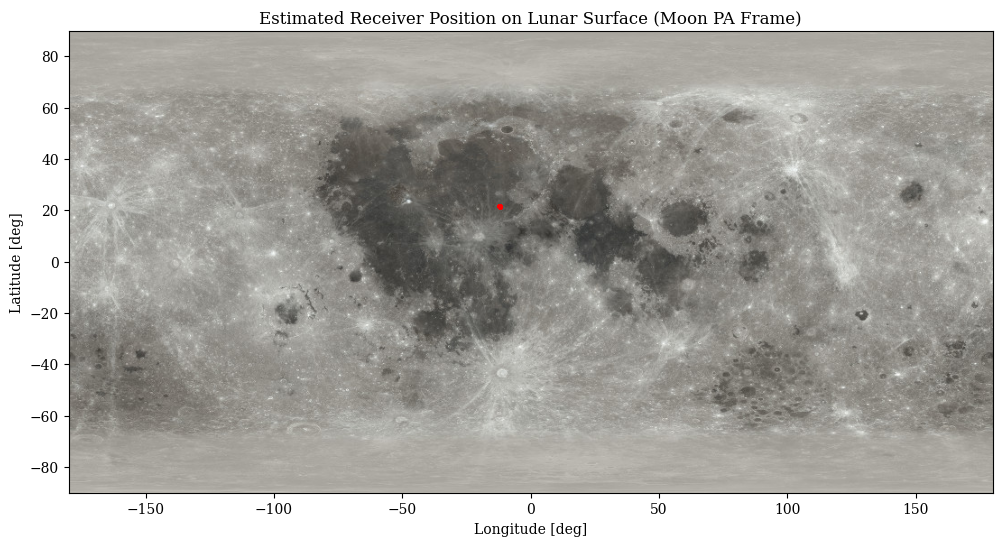

In [9]:
# plot receiver position in Moon PA frame (assert that all positions are on the Moon surface)
if lugre_df["info"]["phase"][0] == 'S':
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xlim(-180,180)
    ax.set_ylim(-90,90)
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")
    ax.set_title("Estimated Receiver Position on Lunar Surface (Moon PA Frame)")

    # load Moon topography image
    img = plt.imread(pnt.LUPNT_DATA_PATH + "/topo/moon_surface.jpeg")
    # flip image vertically and horizontally
    img = img[::-1, ::-1]
    ax.imshow(img, extent=[-180,180,-90,90], alpha=1)

    figobj = [None] * len(rx_mpa)
    for i in range(len(rx_mpa)):
        # lon_rad, lat_rad, _ = pnt.cartesian_to_geographic(rx_mpa[i, 0], rx_mpa[i, 1], rx_mpa[i, 2], pnt.R_MOON)
        lon, lat, _ = glp.ecef_to_geodetic(rx_mpa[i,:])[0]
        # print(f"LL: ({lat}, {lon})")
    #     lon_rad = np.ndarray(lon_rad)
    #     lat_rad = np.ndarray(lat_rad)
    #     lon = lon_rad * pnt.DEG
    #     lat = lat_rad * pnt.DEG
        figobj[i] = ax.plot(lon, lat, 'ro', markersize=2)
    
    # Export figure to pdf
    plt.savefig(savepath.joinpath("NAV_SurfPos.pdf"))

### Plot received C/N0 and corresponding satellite

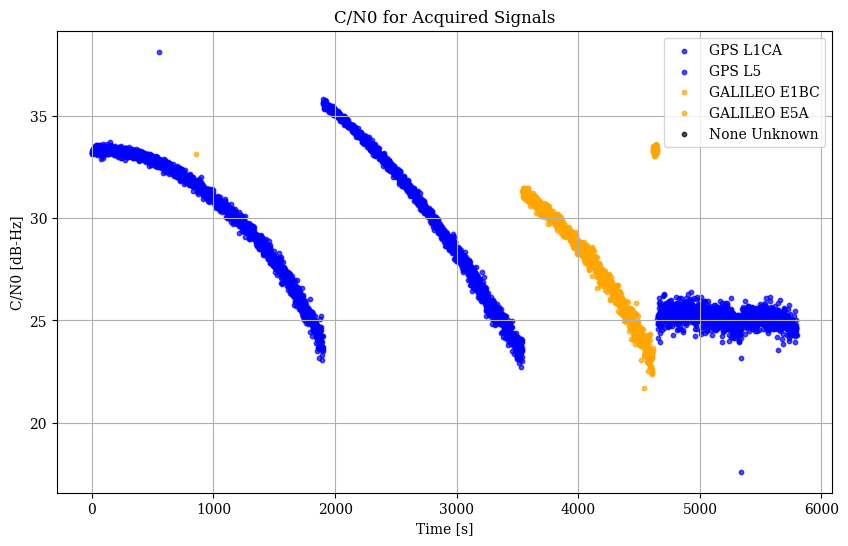

In [10]:
rxTime_acq = lugre_df['raw']["rxTime"].to_numpy()
cn0_acq = lugre_df['raw']["cn0"].to_numpy()
signal_ids = lugre_df['raw']["signalId"].to_numpy()
sv_ids = lugre_df['raw']["svid"].to_numpy()

unique_signal_ids = np.unique(signal_ids)

orbit_colors = {
    "G": "blue",  # GPS
    "E": "orange",  # GALILEO
    "C": "green",  # BEIDOU
    "R": "purple",  # GLONASS
    "J": "red",  # QZSS
}
legend_map = {
    "G": "GPS",
    "E": "GALILEO",
    "C": "BEIDOU",
    "R": "GLONASS",
    "J": "QZSS",
}

plt.figure(figsize=(10, 6))
for signal_id in unique_signal_ids:
    mask = signal_ids == signal_id
    (constellation, band) = get_const_band(signal_id)
    
    plt.scatter(
        rxTime_acq[mask] - rxTime_acq[0],
        cn0_acq[mask],
        label=f"{legend_map.get(constellation)} {band}",
        color=orbit_colors.get(constellation, "black"),
        alpha=0.7,
        s=10,
    )
plt.title("C/N0 for Acquired Signals")
plt.xlabel("Time [s]")
plt.ylabel("C/N0 [dB-Hz]")
plt.legend()
plt.grid()

# Export figure to pdf
plt.savefig(savepath.joinpath("ACQ_CN0.pdf"))
plt.show()

### Plot C/N0 by Signal ID

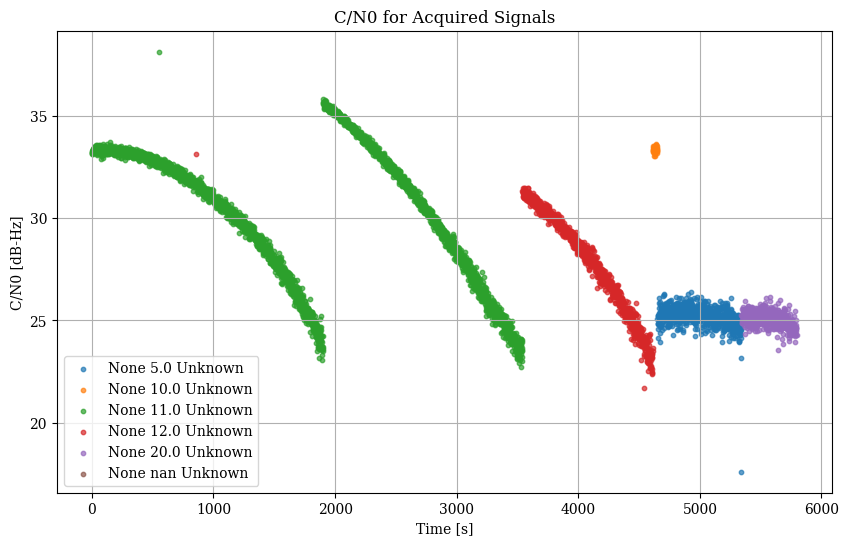

In [11]:
# plot C/N0 for acquired signals
unique_sv_ids = np.unique(sv_ids)
plt.figure(figsize=(10, 6))

for sv_id in unique_sv_ids:
    mask = sv_ids == sv_id
    (constellation, band) = get_const_band(signal_id)
    
    plt.scatter(
        rxTime_acq[mask] - rxTime_acq[0],
        cn0_acq[mask],
        label=f"{legend_map.get(constellation)} {sv_id} {band}",
        alpha=0.7,
        s=10,
    )
plt.title("C/N0 for Acquired Signals")
plt.xlabel("Time [s]")
plt.ylabel("C/N0 [dB-Hz]")
plt.legend()
plt.grid()

# Export figure to pdf
plt.savefig(savepath.joinpath("ACQ_CN0.pdf"))
plt.show()

## Get GNSS data

In [ ]:
# !wget https://raw.githubusercontent.com/Stanford-NavLab/gnss_lib_py/main/data/unit_test/sp3/COD0MGXFIN_20211180000_01D_05M_ORB.SP3 --quiet -nc -O "data/COD0MGXFIN_20250720000_01D_05M_ORB.SP3"
# !wget https://raw.githubusercontent.com/Stanford-NavLab/gnss_lib_py/main/data/unit_test/sp3/COD0MGXFIN_20211180000_01D_05M_ORB.SP3 --quiet -nc -O "data/COD0MGXFIN_20250730000_01D_05M_ORB.SP3"
# !wget https://raw.githubusercontent.com/Stanford-NavLab/gnss_lib_py/main/data/unit_test/sp3/COD0MGXFIN_20211180000_01D_05M_ORB.SP3 --quiet -nc -O "data/COD0MGXFIN_20250740000_01D_05M_ORB.SP3"
# !wget https://raw.githubusercontent.com/Stanford-NavLab/gnss_lib_py/main/data/unit_test/sp3/COD0MGXFIN_20211180000_01D_05M_ORB.SP3 --quiet -nc -O "data/COD0MGXFIN_20250750000_01D_05M_ORB.SP3"
# !wget https://raw.githubusercontent.com/Stanford-NavLab/gnss_lib_py/main/data/unit_test/sp3/COD0MGXFIN_20211180000_01D_05M_ORB.SP3 --quiet -nc -O "data/COD0MGXFIN_20250760000_01D_05M_ORB.SP3"
# !wget https://raw.githubusercontent.com/Stanford-NavLab/gnss_lib_py/main/data/unit_test/sp3/COD0MGXFIN_20211180000_01D_05M_ORB.SP3 --quiet -nc -O "data/COD0MGXFIN_20250770000_01D_05M_ORB.SP3"
# !wget https://raw.githubusercontent.com/Stanford-NavLab/gnss_lib_py/main/data/unit_test/sp3/COD0MGXFIN_20211180000_01D_05M_ORB.SP3 --quiet -nc -O "data/COD0MGXFIN_20250780000_01D_05M_ORB.SP3"

In [31]:
# get precise ephemeris
# print(rxTime_start)
# print(rxTime_nav[0])
print(rxTime_start, rxTime_end)
print(Time(utc_start, scale='utc').gps)
sp3_path = load_ephemeris("sp3", np.array([rxTime_start, rxTime_end]) * 1000, download_directory="data/ephem")
# sp3 = pnt.SP3Loader(target_dt=utc_start, sim_t=24*3600, dt_timesys=pnt.UTC)
sp3 = glp.Sp3(sp3_path)
# print(sp3)
sat_nums = sorted(list(set(map(str, sp3["gnss_sv_id"]))))
# times = sorted(list(set(map(str, sp3["gps_millis"]))))
print("SP3 satellites:", sat_nums)
# print("Times:", times)
# print("SP3 Epochs:", sp3.epochs)
# # print(sp3.__dict__.keys())
# # print(sp3.map)

1426191726.63372 1426197553.43584
1426191726.63372
SP3 satellites: ['C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C48', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E18', 'E19', 'E21', 'E23', 'E24', 'E25', 'E26', 'E27', 'E29', 'E30', 'E31', 'E33', 'E34', 'E36', 'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 'G17', 'G18', 'G19', 'G20', 'G21', 'G22', 'G23', 'G24', 'G25', 'G26', 'G27', 'G28', 'G29', 'G30', 'G31', 'G32', 'J02', 'J03', 'J04', 'R01', 'R02', 'R03', 'R04', 'R05', 'R07', 'R08', 'R09', 'R11', 'R12', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19', 'R20', 'R21', 'R22', 'R24', 'R26']


In [ ]:
pprint(sp3)

         gps_millis gnss_sv_id gnss_id  sv_id        x_sv_m        y_sv_m  \
0      1.426118e+12        G01     gps      1  7.994483e+06  1.443304e+07   
1      1.426118e+12        G02     gps      2  2.340672e+05  1.500809e+07   
2      1.426118e+12        G03     gps      3  1.109388e+07  2.332989e+07   
3      1.426118e+12        G04     gps      4  2.915597e+06  2.024163e+07   
4      1.426118e+12        G05     gps      5 -1.397545e+06 -2.026014e+07   
...             ...        ...     ...    ...           ...           ...   
35253  1.426205e+12        C45  beidou     45  6.809969e+04  1.715677e+07   
35254  1.426205e+12        C48  beidou     48 -1.491667e+07  6.751433e+06   
35255  1.426205e+12        J02    qzss      2 -2.693404e+07  2.386963e+07   
35256  1.426205e+12        J03    qzss      3 -3.459660e+07  1.744675e+07   
35257  1.426205e+12        J04    qzss      4 -2.060276e+07  3.113859e+07   

             z_sv_m  
0     -2.081738e+07  
1     -2.143232e+07  
2     -6.

In [40]:
# get all unique acquired satellites from acq data
keys = []
for index, row in lugre_df["acq"].iterrows():
    prn = int(row['svid'])
    signalId = int(row['signalId'])
    constellation, band = get_const_band(signalId)
    # generate key with leading zeros for prn
    keys.append(f"{constellation}{prn:02d}")

print("All satellites in ACQ data:", keys)
unique_sats = np.unique(keys)
print("Unique satellites in ACQ data:", unique_sats)

# check if all unique satellites are in SP3 data
for key in unique_sats:
    if key not in sat_nums:
        print(f"Warning: Satellite {key} not found in SP3 data.")

All satellites in ACQ data: ['G11', 'E23', 'E10', 'E11', 'E24', 'E04', 'E06', 'E12', 'E31', 'E10', 'E23', 'E33', 'E11', 'E12', 'E31', 'G20', 'E10', 'E23', 'E33', 'E11', 'E24', 'E04', 'E06', 'E12', 'E31', 'E33', 'E11', 'E12', 'E31', 'E10', 'E23', 'E04', 'E06', 'E12', 'E31', 'E10', 'E23', 'E33', 'E11', 'E24', 'E12', 'E31', 'E23', 'E33', 'E04', 'E06', 'E12', 'E31', 'E10', 'E33', 'E24', 'E12', 'E31', 'E10', 'E23', 'E33', 'E11', 'E04', 'E06', 'E31', 'E10', 'E23', 'E33', 'E24', 'E31', 'E10', 'E23', 'E33', 'E04', 'E06', 'E31', 'E10', 'E23', 'E33', 'E11', 'E24', 'E31', 'E10', 'E23', 'E04', 'E06', 'E31', 'E10', 'E23', 'E33', 'E11', 'E24', 'E10', 'E23', 'E06', 'E10', 'E23', 'E33', 'E11', 'E24', 'E04', 'E10', 'E23', 'E33', 'E06', 'E10', 'E23', 'G19', 'E11', 'E24', 'E04', 'E23', 'E06', 'E10', 'E23', 'E33', 'E11', 'E24', 'E04', 'E10', 'E23', 'E33', 'E11', 'E06', 'E10', 'E23', 'E33', 'E11', 'E24', 'E04', 'E10', 'E11', 'E06', 'E10', 'E23', 'E33', 'E24', 'E10', 'E23', 'E33', 'E11', 'E24', 'E04', 'E06'

In [71]:
# Example: Get position, velocity, and clock bias for a specific satellite at a target time
constellation = "E"  # 'G' for GPS, 'R' for GLONASS, 'E' for Galileo, etc.
prn = 2  # PRN number of the satellite
# print(dir(sp3))
# print(sp3[["x_sv_m", "y_sv_m", "z_sv_m"]])

# sp3.interpolate_sp3(sp3)
# print(sp3.interpolate_sp3(glp.NavData()))
# rv_prop, clock_bias = sp3.get_posvelclock(
#     constellation, prn, tai_start, out_frame=pnt.ECEF, propagate=True
# )
# rv_interp, clock_bias_interp = sp3.get_posvelclock(
#     constellation, prn, tai_start, out_frame=pnt.ECEF, propagate=False
# )

# print("RV Propagation for {0}{1:02d} at target TAI:".format(constellation, prn))
# print("Position   [m]     : ", rv_prop[:3])
# print("Velocity   [m/s]   : ", rv_prop[3:])
# print("Clock Bias [micros] : ", clock_bias * 1e6)
# print(" ")
# print("RV Interpolation for {0}{1:02d} at target TAI:".format(constellation, prn))
# print("Position   [m]     : ", rv_interp[:3])
# print("Velocity   [m/s]   : ", rv_interp[3:])
# print("Clock Bias [micros] : ", clock_bias_interp * 1e6)


def sat_id_rows(sp3, sat_str):
    return sp3.pandas_df().loc[sp3.pandas_df()['gnss_sv_id'] == sat_str]

def get_rv(df, sat_str):
    rows = sat_id_rows(df, sat_str)
    return [tuple(i)[1:] for i in rows[["x_sv_m", "y_sv_m", "z_sv_m"]].itertuples()]

print(get_rv(sp3, "G01"))


[(7994483.069999993, 14433035.646999976, -20817382.538999956), (7197451.340000002, 14478854.466999996, -21074216.531999998), (6392405.604485714, 14538954.069257142, -21290711.314257145), (5581132.847977611, 14613547.230778841, -21466459.48157044), (4765434.0080241375, 14702755.747949341, -21601124.999362957), (3947118.674663441, 14806609.941456996, -21694443.67845549), (3128000.395415204, 14925034.12478712, -21746234.831693206), (2309888.512951885, 15057852.378670515, -21756397.20844883), (1494581.2011207286, 15204789.136587039, -21724909.20444894), (683858.5506883966, 15365470.218206216, -21651828.918591835), (-120524.27087451838, 15539424.306259107, -21537294.058605086), (-916843.7412802579, 15726084.859425345, -21381521.69526916), (-1703414.5777698227, 15924792.453705803, -21184807.864091963), (-2478596.1619653674, 16134797.542297827, -20947527.017756525), (-3240798.7706076377, 16355263.623989455, -20670131.326914977), (-3988489.5935501894, 16585270.8039484, -20353149.83269186), (-4

In [38]:
# compute SP3 orbits and clock biases for all satellites
rv_sats_sp3, clock_sats_sp3, sats_list_sp3 = sp3.get_posvelclock_all(
    tspan_tai, out_frame=pnt.ECI, sats_list = unique_sats,propagate=False
)

AttributeError: 'Sp3' object has no attribute 'get_posvelclock_all'

### Plot orbits

In [76]:
# plot orbits and clock biases
fig = go.Figure()

pnt.plot.plot_body(fig, pnt.EARTH, size_factor=5)
# get position of moon
e2m_eci = pnt.get_body_pos_vel(tspan_tai, pnt.EARTH, pnt.MOON, pnt.ECI)

orbit_colors = {
    "G": "blue",  # GPS
    "E": "orange",  # GALILEO
    "C": "green",  # BEIDOU
    "R": "purple",  # GLONASS
    "J": "red",  # QZSS
}

gnss_consts = ["G", "E", "C", "R", "J"]  # GPS, GALILEO, BEIDOU, QZSS

# # gnss
# for gnss_const in gnss_consts:
#     sat_idx = [i for i, sat in enumerate(unique_sats) if sat.startswith(gnss_const)]
#     sats = 
#     pnt.plot.plot_orbits(
#         fig, 
#         get_rv(sp3, sat_idx[0]),
#         # rv_sats_sp3[sat_idx, :, :], 
#         t=0, 
#         color=orbit_colors[gnss_const]
#     )
# # plot moon direction
# pnt.plot.plot_arrow3(fig, np.zeros(3), e2m_eci[:, :3]/10, length = 1.5, tip = 0.2, color='gray')
# pnt.plot.set_view(fig, -80, 20, 2.5)
# fig.update_layout(showlegend=True, width=400, height=400)
# fig.show()

# plot clock biases
Cms = 299792458  # Convert clock bias from seconds to meters
plt.figure(figsize=(6, 3))
for i, sat in enumerate(sats_list_sp3):
    plt.plot(
        tspan_tai - tspan_tai[0],
        (clock_sats_sp3[i] - clock_sats_sp3[i][0]) * Cms,
        label=f"Satellite {sat}",
        alpha=0.7,
    )
plt.title("Clock Biases for Satellites")
plt.xlabel("Time [s]")
plt.ylabel("Clock Bias [m]")
plt.grid()
plt.show()

NameError: name 'sats_list_sp3' is not defined

<Figure size 600x300 with 0 Axes>

## Calculate C/N0